<a href="https://colab.research.google.com/github/maro9450/SML/blob/main/lab/mnist_fivelayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporarily patch this script until the MNIST data set download issue is resolved
# https://github.com/pytorch/vision/issues/1938
import urllib.request
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Classification of hand-written digits

We start by downloading and extracting the MNIST data set.

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 35.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.23MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.4MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.25MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## The first model
We start by adding five layers to the neural net, while still using the sigmoid function between the hidden layers.

### The model

The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel. We then apply first the sigmoid $Q=\sigma (X W^{(1)} + b^{(1)})$ for the hidden layer, and then apply the softmax to $QW^{(2)} + b^{(2)}$ to get the class probabilities.

In [3]:
class Net(nn.Module):
    def __init__(self, U=[200,100,60,30]):
        super(Net, self).__init__()
        # parameters
        self.W1 = nn.Parameter(0.1 * torch.randn(784, U[0]))
        self.b1 = nn.Parameter(torch.zeros(U[0]))
        self.W2 = nn.Parameter(0.1 * torch.randn(U[0], U[1]))
        self.b2 = nn.Parameter(torch.zeros(U[1]))
        self.W3 = nn.Parameter(0.1 * torch.randn(U[1], U[2]))
        self.b3 = nn.Parameter(torch.zeros(U[2]))
        self.W4 = nn.Parameter(0.1 * torch.randn(U[2], U[3]))
        self.b4 = nn.Parameter(torch.zeros(U[3]))
        self.W5 = nn.Parameter(0.1 * torch.randn(U[3], 10))
        self.b5 = nn.Parameter(torch.zeros(10))


    def forward(self, X):
        # flatten the data into a matrix with 28 x 28 = 784 columns
        X = X.view(-1, 784)
        # sigmoided hidden layers
        Q1 = torch.sigmoid(X.mm(self.W1) + self.b1)
        Q2 = torch.sigmoid(Q1.mm(self.W2) + self.b2)
        Q3 = torch.sigmoid(Q2.mm(self.W3) + self.b3)
        Q4 = torch.sigmoid(Q3.mm(self.W4) + self.b4)
        # apply the softmax function
        G = F.softmax(Q4.mm(self.W5) + self.b5, dim=1)
        return G

### The training

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9).

In [4]:
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = torch.eye(10, device=device)[Y] #n*10 tensor of n 1-hot-encoded Y:s

    return -(Y_onehot * G.log()).sum(dim = 1).mean() #cost (eq 10)

The next lines evaluate the accuracy of the predictions.

In [5]:
def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

We are ready to train the network.

In [6]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []


# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.5
optimizer = optim.SGD(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 2000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = crossentropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy  16.00% train cross-entropy  2.31  test accuracy   9.82% test cross-entropy  2.32
Step   100: train accuracy  10.00% train cross-entropy  2.31  test accuracy  10.43% test cross-entropy  2.31
Step   200: train accuracy   7.00% train cross-entropy  2.31  test accuracy   8.92% test cross-entropy  2.31
Step   300: train accuracy   5.00% train cross-entropy  2.33  test accuracy  16.01% test cross-entropy  2.30
Step   400: train accuracy  13.00% train cross-entropy  2.29  test accuracy  10.10% test cross-entropy  2.31
Step   500: train accuracy  14.00% train cross-entropy  2.30  test accuracy  19.37% test cross-entropy  2.28
Step   600: train accuracy  22.00% train cross-entropy  2.06  test accuracy  24.74% test cross-entropy  2.03
Step   700: train accuracy  29.00% train cross-entropy  1.74  test accuracy  28.49% test cross-entropy  1.75
Step   800: train accuracy  27.00% train cross-entropy  1.75  test accuracy  32.89% test cross-entropy  1.66
Step   900: train a

### The evaluation

The remaining code produces the plots needed to evaluate the training and predictions.

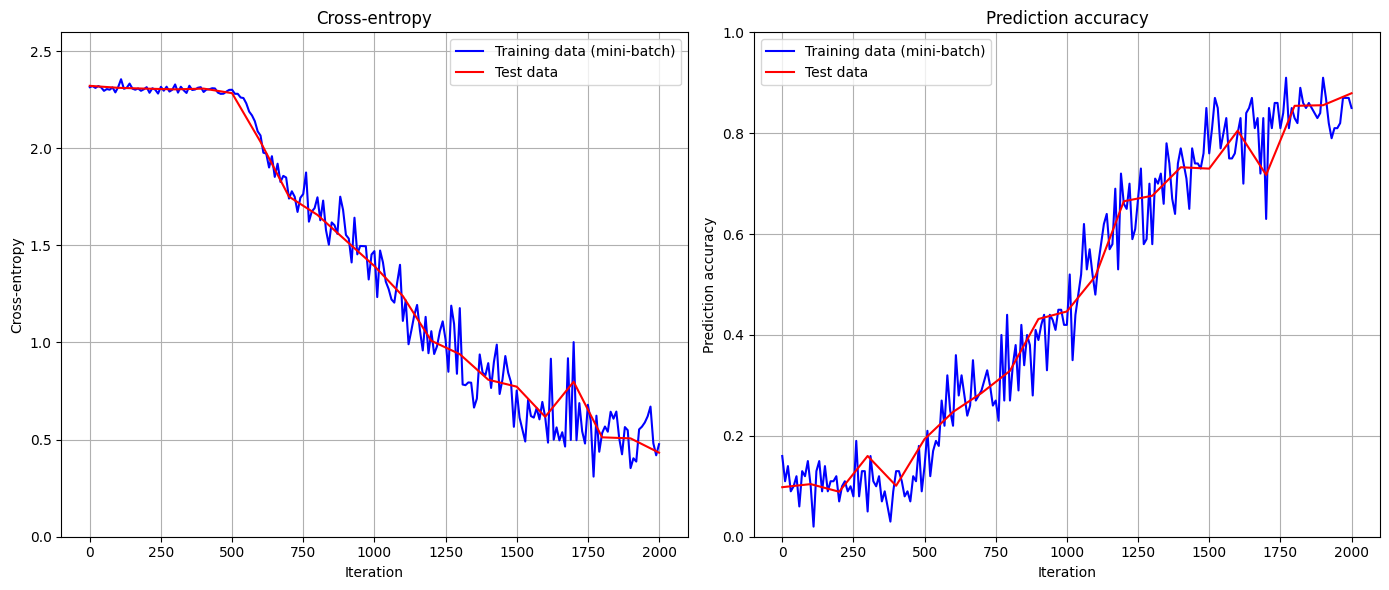

In [11]:
# Set up the 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1st Subplot: Cross-Entropy
axes[0].plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
axes[0].plot(test_iter, test_crossentropy, 'r-', label='Test data')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cross-entropy')
axes[0].set_ylim([0, min(test_crossentropy) * 6])
axes[0].set_title('Cross-entropy')
axes[0].grid(True)
axes[0].legend(loc='best')

# 2nd Subplot: Prediction Accuracy
axes[1].plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
axes[1].plot(test_iter, test_accuracy, 'r-', label='Test data')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Prediction accuracy')
axes[1].set_ylim([0, 1])
axes[1].set_title('Prediction accuracy')
axes[1].grid(True)
axes[1].legend(loc='best')

# Adjust layout for readability
plt.tight_layout()
plt.show()

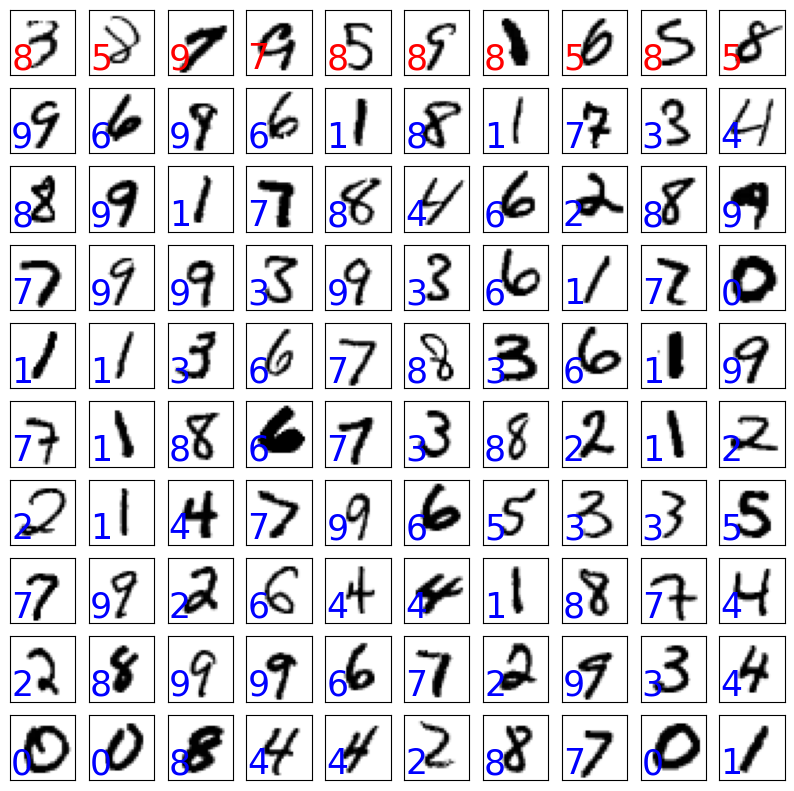

In [12]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))

    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)

    # compute the predictions for the sampled inputs
    random_G = net(random_X)
    random_Yhat = random_G.argmax(dim=1)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])

    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)

    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)

plt.show()

## The second model
We now replace the sigmoid function with the ReLU function between the layers, changing initial offset values, and the optimizer.

### The model

The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel. For the hidden layers we use the ReLU function. The first hidden layer is then given by $Q^{(1)}=\max(0,XW^{(1)}+b^{(1)})$, the second $Q^{(2)}=\max(0,Q^{(1)}W^{(2)}+b^{(2)})$, etc... For the final layer we still apply the softmax for the probability.

In [13]:
class Net(nn.Module):
    def __init__(self, U=[200,100,60,30]):
        super(Net, self).__init__()
        # parameters
        self.W1 = nn.Parameter(0.1 * torch.randn(784, U[0]))
        self.b1 = nn.Parameter(torch.ones(U[0]) / U[0])
        self.W2 = nn.Parameter(0.1 * torch.randn(U[0], U[1]))
        self.b2 = nn.Parameter(torch.ones(U[1]) / U[1])
        self.W3 = nn.Parameter(0.1 * torch.randn(U[1], U[2]))
        self.b3 = nn.Parameter(torch.ones(U[2]) / U[2])
        self.W4 = nn.Parameter(0.1 * torch.randn(U[2], U[3]))
        self.b4 = nn.Parameter(torch.ones(U[3]) / U[3])
        self.W5 = nn.Parameter(0.1 * torch.randn(U[3], 10))
        self.b5 = nn.Parameter(torch.ones(10)/10)


    def forward(self, X):
        # flatten the data into a matrix with 28 x 28 = 784 columns
        X = X.view(-1, 784)
        # sigmoided hidden layers
        Q1 = torch.sigmoid(X.mm(self.W1) + self.b1)
        Q2 = torch.sigmoid(Q1.mm(self.W2) + self.b2)
        Q3 = torch.sigmoid(Q2.mm(self.W3) + self.b3)
        Q4 = torch.sigmoid(Q3.mm(self.W4) + self.b4)
        # apply the softmax function
        G = F.softmax(Q4.mm(self.W5) + self.b5, dim=1)
        return G

## Training and evaluation ($n=2000$)
We need not change any of the functions for calculating entropy or accuracy. However, we will now change the SGD optimizer to the Adam-optimizer as well as change the learning rate to accomodate this change.

In [14]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []


# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.003
optimizer = optim.Adam(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 2000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = crossentropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy   8.00% train cross-entropy  2.30  test accuracy  10.28% test cross-entropy  2.32
Step   100: train accuracy  69.00% train cross-entropy  1.30  test accuracy  68.99% test cross-entropy  1.26
Step   200: train accuracy  87.00% train cross-entropy  0.73  test accuracy  82.63% test cross-entropy  0.72
Step   300: train accuracy  93.00% train cross-entropy  0.47  test accuracy  90.02% test cross-entropy  0.45
Step   400: train accuracy  97.00% train cross-entropy  0.18  test accuracy  92.46% test cross-entropy  0.32
Step   500: train accuracy  90.00% train cross-entropy  0.37  test accuracy  93.70% test cross-entropy  0.26
Step   600: train accuracy  97.00% train cross-entropy  0.13  test accuracy  94.56% test cross-entropy  0.22
Step   700: train accuracy  95.00% train cross-entropy  0.16  test accuracy  94.63% test cross-entropy  0.20
Step   800: train accuracy  96.00% train cross-entropy  0.18  test accuracy  95.44% test cross-entropy  0.18
Step   900: train a

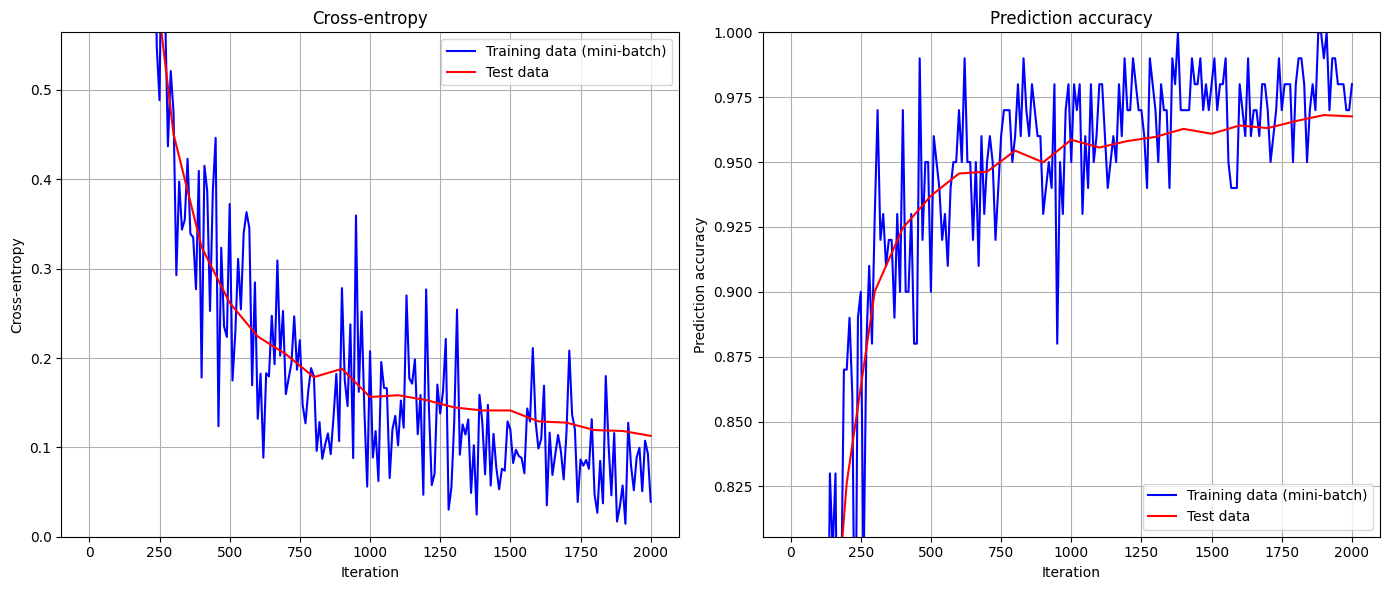

In [17]:
# Set up the 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1st Subplot: Cross-Entropy
axes[0].plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
axes[0].plot(test_iter, test_crossentropy, 'r-', label='Test data')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cross-entropy')
axes[0].set_ylim([0, min(test_crossentropy) * 5])
axes[0].set_title('Cross-entropy')
axes[0].grid(True)
axes[0].legend(loc='best')

# 2nd Subplot: Prediction Accuracy
axes[1].plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
axes[1].plot(test_iter, test_accuracy, 'r-', label='Test data')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Prediction accuracy')
axes[1].set_ylim([max(1 - (1 - test_accuracy[-1]) * 6, 0), 1])
axes[1].set_title('Prediction accuracy')
axes[1].grid(True)
axes[1].legend(loc='best')

# Adjust layout for readability
plt.tight_layout()
plt.show()

### Longer training ($n=10000$)
We now let the model train with a total of 10000 iterations

In [18]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []


# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.003
optimizer = optim.Adam(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 10000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = crossentropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

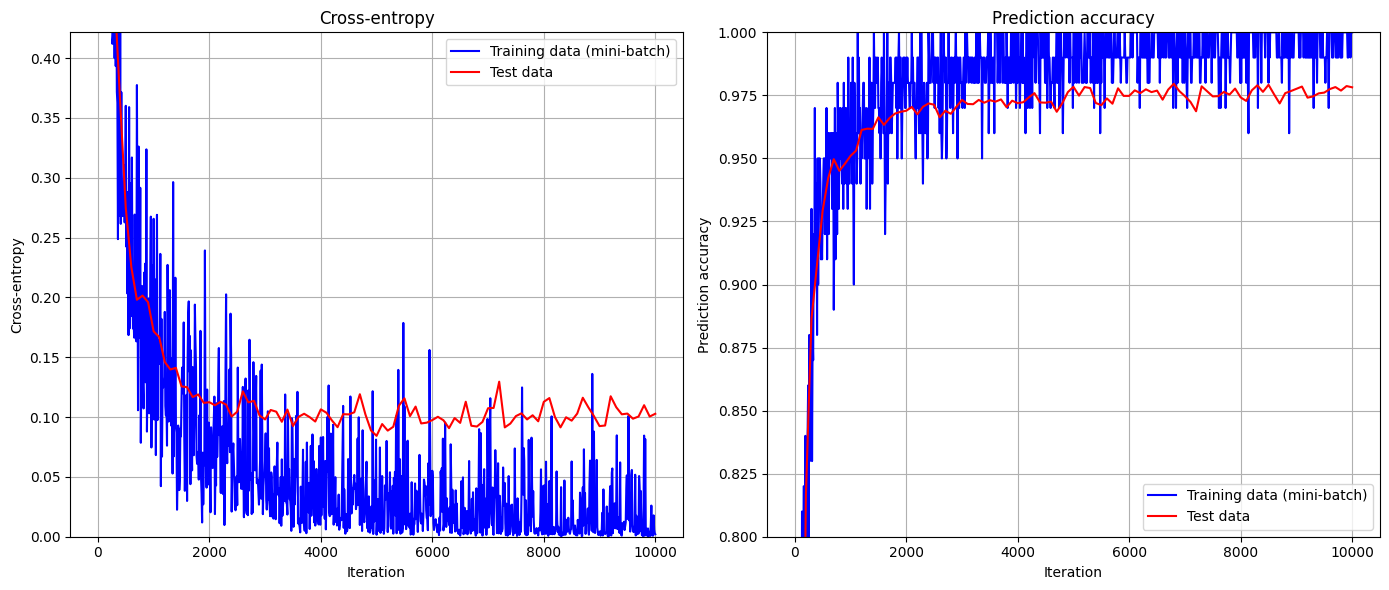

In [23]:
# Set up the 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1st Subplot: Cross-Entropy
axes[0].plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
axes[0].plot(test_iter, test_crossentropy, 'r-', label='Test data')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cross-entropy')
axes[0].set_ylim([0, min(test_crossentropy) * 5])
axes[0].set_title('Cross-entropy')
axes[0].grid(True)
axes[0].legend(loc='best')

# 2nd Subplot: Prediction Accuracy
axes[1].plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
axes[1].plot(test_iter, test_accuracy, 'r-', label='Test data')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Prediction accuracy')
axes[1].set_ylim([0.8, 1])
axes[1].set_title('Prediction accuracy')
axes[1].grid(True)
axes[1].legend(loc='best')

# Adjust layout for readability
plt.tight_layout()
plt.show()

## The third model

We want to safeguard against some possible numerical issues for longer training periods by changing how we calculate the cross-entropy.

### The model
We change the forward pass to instead return the logit.

In [24]:
class Net(nn.Module):
    def __init__(self, U=[200,100,60,30]):
        super(Net, self).__init__()
        # parameters
        self.W1 = nn.Parameter(0.1 * torch.randn(784, U[0]))
        self.b1 = nn.Parameter(torch.ones(U[0]) / U[0])
        self.W2 = nn.Parameter(0.1 * torch.randn(U[0], U[1]))
        self.b2 = nn.Parameter(torch.ones(U[1]) / U[1])
        self.W3 = nn.Parameter(0.1 * torch.randn(U[1], U[2]))
        self.b3 = nn.Parameter(torch.ones(U[2]) / U[2])
        self.W4 = nn.Parameter(0.1 * torch.randn(U[2], U[3]))
        self.b4 = nn.Parameter(torch.ones(U[3]) / U[3])
        self.W5 = nn.Parameter(0.1 * torch.randn(U[3], 10))
        self.b5 = nn.Parameter(torch.ones(10)/10)


    def forward(self, X):
        # flatten the data into a matrix with 28 x 28 = 784 columns
        X = X.view(-1, 784)
        # sigmoided hidden layers
        Q1 = torch.sigmoid(X.mm(self.W1) + self.b1)
        Q2 = torch.sigmoid(Q1.mm(self.W2) + self.b2)
        Q3 = torch.sigmoid(Q2.mm(self.W3) + self.b3)
        Q4 = torch.sigmoid(Q3.mm(self.W4) + self.b4)
        # return the logit
        Z = Q4.mm(self.W5) + self.b5
        return Z

### Training and evaluation
We change the training section so that we now use ```F.cross_entropy()``` for the loss instead of the ```crossentropy()``` function previously defined.



In [28]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []


# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.003
optimizer = optim.Adam(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 10000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        #now using F.cross_entropy() for loss
        loss = F.cross_entropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(F.cross_entropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Plotting the results:

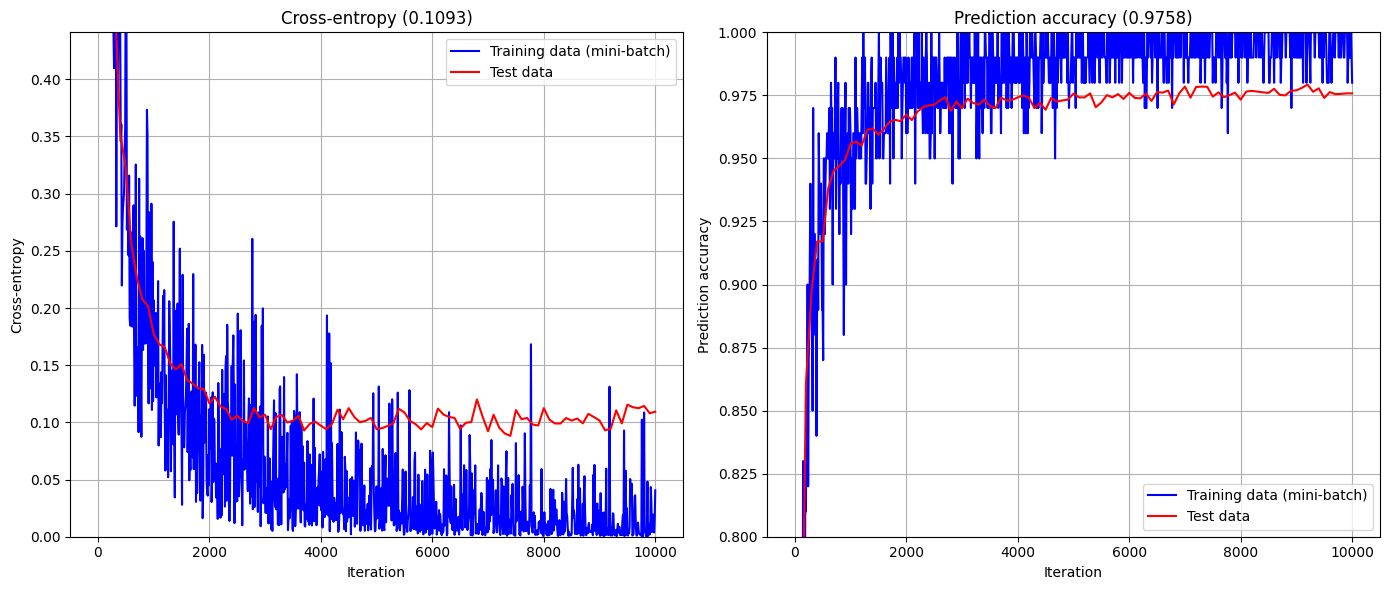

In [39]:
# Set up the 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1st Subplot: Cross-Entropy
axes[0].plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
axes[0].plot(test_iter, test_crossentropy, 'r-', label='Test data')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cross-entropy')
axes[0].set_ylim([0, min(test_crossentropy) * 5])
axes[0].set_title(f'Cross-entropy ({test_crossentropy[-1]:1.4f})')
axes[0].grid(True)
axes[0].legend(loc='best')

# 2nd Subplot: Prediction Accuracy
axes[1].plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
axes[1].plot(test_iter, test_accuracy, 'r-', label='Test data')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Prediction accuracy')
axes[1].set_ylim([0.8, 1])
axes[1].set_title(f'Prediction accuracy ({test_accuracy[-1]:1.4f})')
axes[1].grid(True)
axes[1].legend(loc='best')

# Adjust layout for readability
plt.tight_layout()
plt.show()